In [4]:
#importing dependencies
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

AttributeError: module 'tensorflow.python.training.experimental.mixed_precision' has no attribute '_register_wrapper_optimizer_cls'

In [2]:
import tensorflow as tf
print(tf.__version__)

AttributeError: module 'tensorflow.python.training.experimental.mixed_precision' has no attribute '_register_wrapper_optimizer_cls'

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
#load all images into dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
	"PlantVillage",
	shuffle = True,
	image_size = (IMAGE_SIZE,IMAGE_SIZE),
	batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
#every element in the dataset is a batch of 32 
len(dataset)

68

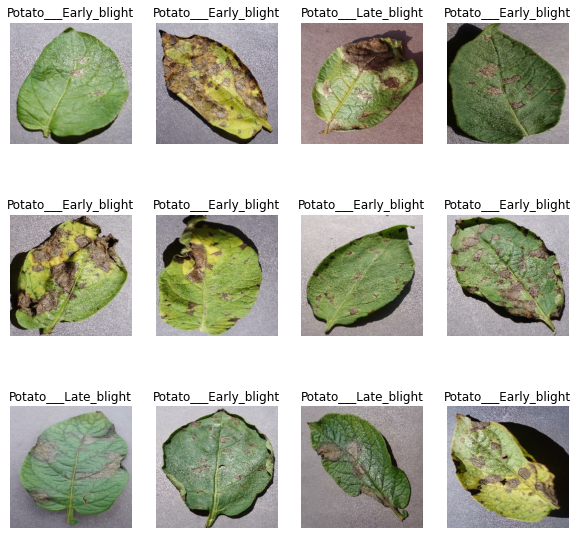

In [6]:
# 3 in output is rgb channels
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch[0].numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    #print(image_batch.shape)  
    #print(label_batch.numpy()) #convert tensor into numpy

In [7]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
print(f"len(train_ds) : {len(train_ds)}")
print(f"len(test_ds) : {len(test_ds)}")
print(f"len(val_ds) : {len(val_ds)}")

len(train_ds) : 54
len(test_ds) : 8
len(val_ds) : 6


In [10]:
#caching - read image from disk and for next iteration it keeps image in the memory, improves efficiency
#if gpu is busy training then prefetch will load next set of batch from disk
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
#when a trained model starts predicting, if an image is of different layer then resize it
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    #conv layer
    layers.Conv2D(32, (3,3), activation = 'relu',  input_shape = input_shape), #32 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    #conv layer
    layers.Conv2D(64, (3,3), activation = 'relu'), #64 layers , actual filter size, activation layer
    #pooling layer
    layers.MaxPooling2D((2,2)),
    
    #flatten layers into array of neurons and dense layers
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),  #normalize probability of classes
    
])
model.build(input_shape = input_shape)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
model.compile(optimizer = 'adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics = ['accuracy']
)


In [15]:
history = model.fit(
train_ds,
epochs = EPOCHS,
batch_size = BATCH_SIZE,
verbose = 1,
validation_data = val_ds
)

Epoch 1/5
54/54 [==============================] - 86s 1s/step - loss: 0.9038 - accuracy: 0.4800 - val_loss: 0.8848 - val_accuracy: 0.4792
Epoch 2/5
54/54 [==============================] - 79s 1s/step - loss: 0.7372 - accuracy: 0.6725 - val_loss: 0.5018 - val_accuracy: 0.8125
Epoch 3/5
54/54 [==============================] - 77s 1s/step - loss: 0.4225 - accuracy: 0.8222 - val_loss: 0.2687 - val_accuracy: 0.8646
Epoch 4/5
54/54 [==============================] - 79s 1s/step - loss: 0.2980 - accuracy: 0.8877 - val_loss: 0.2652 - val_accuracy: 0.8958
Epoch 5/5
54/54 [==============================] - 77s 1s/step - loss: 0.2289 - accuracy: 0.9132 - val_loss: 0.1848 - val_accuracy: 0.9115


In [2]:
scores = model.evaluate(test_ds)

NameError: name 'model' is not defined

In [17]:
scores #python list with loss and accuracy

[0.19574107229709625, 0.931034505367279]

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

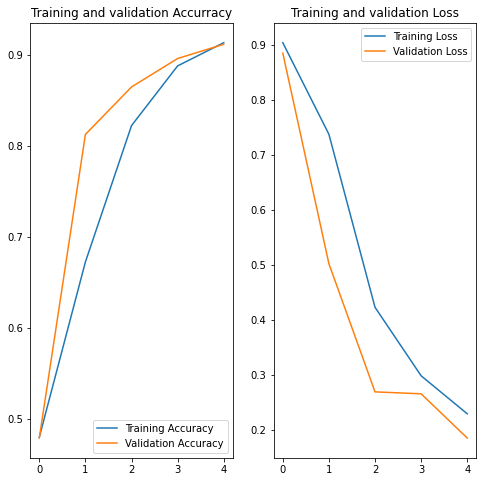

In [19]:
#x axis - epochs
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation Accurracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation Loss')
plt.show()

First image to predict
actual label:  Potato___Late_blight
1/1 [==============================] - 1s 520ms/step
predicted label:  Potato___Late_blight


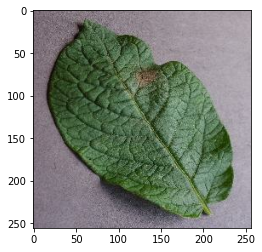

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    #tensor converted to numpy
    #plt.imshow(images_batch[0].numpy().astype('uint8')) 
    #print(images_batch[0].numpy().astype('uint8')) 3D array RGB
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label: ",class_names[first_label])
    #prediction for batch of 32 images
    batch_prediction = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])]) #for one image

In [21]:
def predict1(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[1].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence #accuracy of prediction is 100%, confidence 100%

In [22]:
def predict(model, img_path):
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [23]:
predicted_class, confidence = predict(model, "my_image.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 99ms/step
Predicted class: Potato___Early_blight
Confidence: 80.18%


In [24]:
predicted_class, confidence = predict(model, "my_image_LB1.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 33ms/step
Predicted class: Potato___Early_blight
Confidence: 59.48%


In [25]:
predicted_class, confidence = predict(model, "my_image_LB2.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 37ms/step
Predicted class: Potato___Early_blight
Confidence: 63.34%


In [26]:
predicted_class, confidence = predict(model, "my_image_h.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 29ms/step
Predicted class: Potato___Late_blight
Confidence: 88.31%


In [27]:
predicted_class, confidence = predict(model, "my_image_h1.jpg")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}%")

1/1 [==============================] - 0s 30ms/step
Predicted class: Potato___healthy
Confidence: 96.19%


1/1 [==============================] - 0s 30ms/step


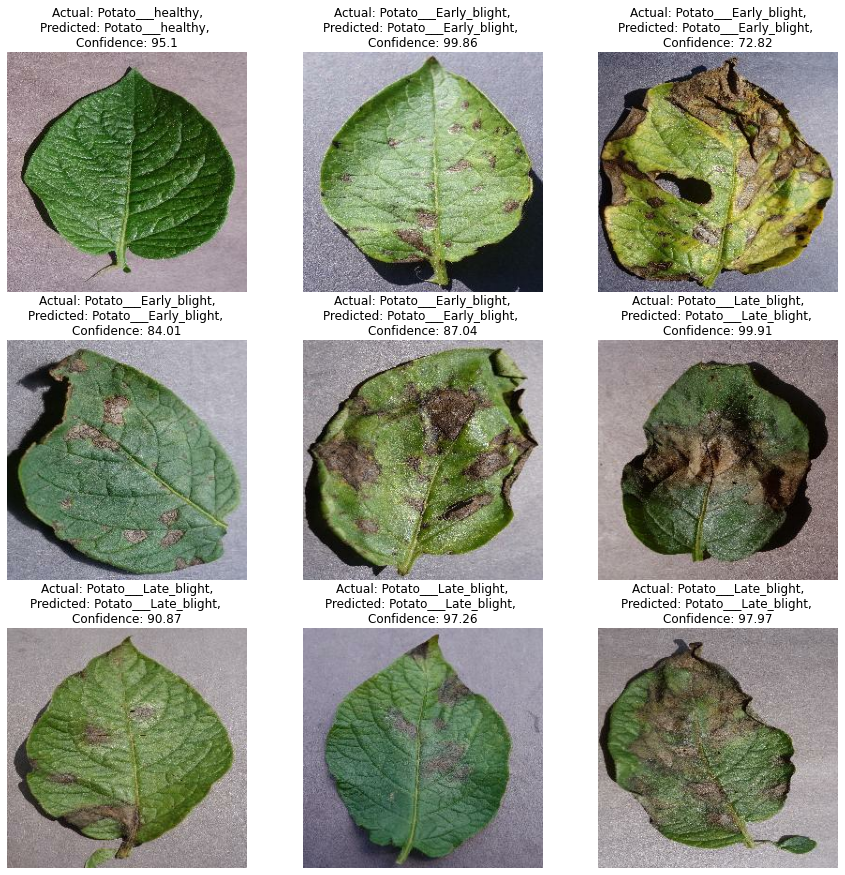

In [28]:
def predict(model, img_array):
    img = tf.keras.preprocessing.image.array_to_img(img_array)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}, \nConfidence: {confidence}")
        
        plt.axis("off")

In [29]:
import os
model_version = max([int(i) for i in os.listdir("../m") + [0]])+1
model.save(f"../m/{model_version}.h5")

ValueError: invalid literal for int() with base 10: '1.h5'